#  Distance between cities

In [217]:
import pandas as pd
from simpledbf import Dbf5 as db
import numpy as np
import matplotlib.pyplot as plt

### Reading all dbf files and converting to dataframe

In [218]:
list_of_dbfs = ["brasil_north_points.dbf", "brasil_central_points.dbf","brasil_east_points.dbf",
                "brasil_mg_points.dbf","brasil_northeast_points.dbf",
                "brasil_PointDistance_south.dbf","brasil_rs_points.dbf","brasil_sp_points.dbf"]
def read_dbf(dbf_text):
    dbf = db(dbf_text)
    df_all = dbf.to_dataframe()
    return df_all
dbfs_read = [read_dbf(list_of_dbfs[i]) for i in range(len(list_of_dbfs))]

### Concating to get a single distances dataframe

In [219]:
concat_states = pd.concat([dbfs_read[i] for i in range(len(list_of_dbfs))])

In [220]:
concat_states.head()

,INPUT_FID,NEAR_FID,DISTANCE
0,2,3792,17.377536
1,2,1446,16.903538
2,2,1335,16.759935
3,2,1242,17.004500
4,2,844,17.025101


### Reading sheets with city names and population

In [221]:
list_of_sheets = ["North","Central","East","MG","Northeast","South","RS","SP"]
sheets_read = [pd.read_excel("output_distance.xlsx",sheet_name=list_of_sheets[i]) for i in range(len(list_of_sheets))]
sheets_read[1].head()

,Unnamed: 0,NAME,POPULAÇÃO ESTIMADA,STATE
0,5,Brasília/DF,2914830,DF
1,6,Campo Grande/MS,853622,MS
2,7,Cuiabá/MT,580489,MT
3,11,Goiânia/GO,1430697,GO
4,17,Palmas/TO,272726,TO


### Concating to get a single population dataframe

In [222]:
concat_sheets = pd.concat([sheets_read[i] for i in range(len(list_of_sheets))])
concat_sheets = concat_sheets.rename(columns={'Unnamed: 0': 'INPUT_FID'})
concat_sheets.head()

,INPUT_FID,NAME,POPULAÇÃO ESTIMADA,STATE
0,2,Belém/PA,1439561,PA
1,4,Boa Vista/RR,320714,RR
2,13,Macapá/AP,456171,AP
3,15,Manaus/AM,2057711,AM
4,19,Porto Velho/RO,502748,RO


### Extracting each state from the population dataframe

In [265]:
pat = ["(.*\/PA)","(.*\/RR)","(.*\/AP)","(.*\/AM)","(.*\/RO)","(.*\/AC)","(.*\/MA)","(.*\/PI)",
       "(.*\/MS)","(.*\/MT)","(.*\/GO)","(.*\/TO)","(.*\/SE)","(.*\/AL)","(.*\/RJ)","(.*\/BA)","(.*\/ES)"
       ,"(.*\/MG)","(.*\/CE)","(.*\/PB)","(.*\/RN)","(.*\/PE)","(.*\/PR)","(.*\/SC)","(.*\/RS)","(.*\/SP)"]
copy_list = [concat_sheets.copy() for i in range(len(pat))]
for i in range(len(pat)):
    copy_list[i]["NAME"] = concat_sheets["NAME"].str.extract(pat[i])
    copy_list[i] = copy_list[i].dropna()
copy_list[2].head()

,INPUT_FID,NAME,POPULAÇÃO ESTIMADA,STATE
2,13,Macapá/AP,456171,AP
41,213,Amapá/AP,8622,AP
155,922,Calçoene/AP,10163,AP
239,1541,Cutias/AP,5407,AP
264,1795,Ferreira Gomes/AP,6901,AP


### Spliting the concated distances dataframe in dataframes representing each state

In [266]:
states = [concat_states[concat_states['NEAR_FID'].isin(copy_list[i]['INPUT_FID'])] 
          for i in range(len(pat))]
states[3]

,INPUT_FID,NEAR_FID,DISTANCE
79,2,673,20.253862
135,2,1996,24.838286
137,2,2250,23.856492
138,2,1693,22.333761
139,2,1659,21.994621
...,...,...,...
560074,5559,3263,10.940252
560077,5559,566,11.255070
560185,5559,4656,21.491772
560186,5559,4406,19.402464


### Merging distances dataframe with population dataframe.

In [225]:
merged_states = [copy_list[i].merge(states[i]) for i in range(len(pat))]
merged_states[1].head()

,INPUT_FID,NAME,POPULAÇÃO ESTIMADA,STATE,NEAR_FID,DISTANCE
0,4,Boa Vista/RR,320714,RR,1104,1.102300
1,4,Boa Vista/RR,320714,RR,4812,1.886386
2,4,Boa Vista/RR,320714,RR,4682,2.018375
3,4,Boa Vista/RR,320714,RR,4272,1.891279
4,4,Boa Vista/RR,320714,RR,1163,2.168565


### Grouping by state,city name and population to find the cities with the least summed distance

In [263]:
grouped_states = [merged_states[i].groupby(['STATE','NAME','POPULAÇÃO ESTIMADA'], as_index=False)
                  ['DISTANCE'].sum().sort_values(by="DISTANCE",axis=0) for i in range(len(pat))]
grouped_states[25].head()

,STATE,NAME,POPULAÇÃO ESTIMADA,DISTANCE
49,SP,Bariri/SP,34048,1238.308948
68,SP,Bocaina/SP,11810,1239.751583
245,SP,Itaju/SP,3606,1240.800233
255,SP,Itapuí/SP,13328,1241.164064
73,SP,Boracéia/SP,4631,1241.194092


### Getting the least and most centralized cities in each state

In [260]:
min_states = pd.Series({i: grouped_states[i][grouped_states[i]['DISTANCE'] ==
                                  grouped_states[i]['DISTANCE'].min()]["NAME"].to_numpy()[0]
                  for i in range(len(pat))}).sort_values()

max_states = pd.Series({i: grouped_states[i][grouped_states[i]['DISTANCE'] ==
                                  grouped_states[i]['DISTANCE'].max()]["NAME"].to_numpy()[0]
                  for i in range(len(pat))}).sort_values()

print("Most centralized")
min_states.head(10)

Most centralized


25             Bariri/SP
17     Belo Horizonte/MG
20               Bodó/RN
1               Cantá/RR
3             Codajás/AM
2      Ferreira Gomes/AP
24    Fontoura Xavier/RS
22      Godoy Moreira/PR
0        Igarapé-Miri/PA
10            Inhumas/GO
dtype: object

In [261]:
print("Least centralized")
max_states.head(10)

Least centralized


21                     Afrânio/PE
6                Alto Parnaíba/MA
11                    Araguaçu/TO
24             Barra do Quaraí/RS
19        Cachoeira dos Índios/PB
12    Canindé de São Francisco/SE
17                 Carneirinho/MG
8                      Corumbá/MS
7        Cristalândia do Piauí/PI
23          Dionísio Cerqueira/SC
dtype: object

### Getting the 10 most and 10 least centralized cities in each state

In [229]:
df_first_10 = [grouped_states[i].head(10) for i in range(len(pat))]
df_last_10 = [grouped_states[i].tail(10).sort_values(by="DISTANCE",ascending=False)
              for i in range(len(pat))]

In [232]:
capitals = pd.read_excel("output_distance.xlsx",sheet_name="Capitals")

### Percent of cities more centralized than the capital

In [267]:
position_capitals = {}
number_of_cities = {}
for i in range(len(pat)):
    
    grouped_states[i] = grouped_states[i].set_index(np.arange(0, len(grouped_states[i])))
    
    position_capitals[grouped_states[i][grouped_states[i]['NAME']
                                    .isin(capitals['NAME'])]["NAME"].to_numpy()[0]] = \
    grouped_states[i][grouped_states[i]['NAME'].isin(capitals['NAME'])].index.to_numpy()[0]
    
    number_of_cities[grouped_states[i][grouped_states[i]['NAME']
                    .isin(capitals['NAME'])]["STATE"].to_numpy()[0]] = len(grouped_states[i])

capital_position = pd.Series(position_capitals)

In [251]:
cities_per_state = pd.Series(number_of_cities)

In [252]:
indexes = list(capital_position.index)
percent_cities = pd.Series({indexes[i]: (capital_position[i]/cities_per_state[i])*100 
               for i in range(len(cities_per_state))})
percent_cities_sort = percent_cities.sort_values()

In [253]:
percent_cities_sort

Belo Horizonte/MG     0.000000
Boa Vista/RR          6.666667
Belém/PA              9.090909
Goiânia/GO            9.349593
Palmas/TO            11.510791
Campo Grande/MS      16.883117
Cuiabá/MT            17.985612
Manaus/AM            20.967742
Rio Branco/AC        22.727273
Vitória/ES           30.769231
Rio de Janeiro/RJ    36.956522
Aracaju/SE           37.333333
Salvador/BA          39.808153
Macapá/AP            43.750000
São Luís/MA          47.926267
Teresina/PI          48.648649
Fortaleza/CE         52.173913
Maceió/AL            56.862745
Porto Alegre/RS      61.770624
São Paulo/SP         70.077519
Recife/PE            73.369565
Florianópolis/SC     74.402730
Natal/RN             76.047904
João Pessoa/PB       88.340807
Porto Velho/RO       94.230769
Curitiba/PR          94.235589
dtype: float64

### Least centralized capitals

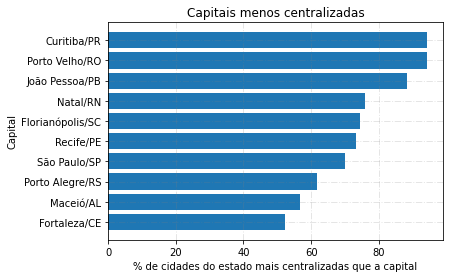

In [254]:
percent_cities = percent_cities.sort_values(ascending=True)
plt.barh(percent_cities.tail(10).index,percent_cities.tail(10).values)
plt.title("Capitais menos centralizadas")
plt.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1,
        alpha = 0.2)
plt.xlabel('% de cidades do estado mais centralizadas que a capital')
plt.ylabel('Capital')
plt.show()

### Most centralized capitals

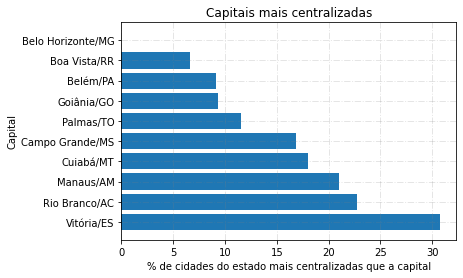

In [255]:
percent_cities = percent_cities.sort_values(ascending=False)
plt.barh(percent_cities.tail(10).index,percent_cities.tail(10).values)
plt.title("Capitais mais centralizadas")
plt.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 1,
        alpha = 0.2)
plt.xlabel('% de cidades do estado mais centralizadas que a capital')
plt.ylabel('Capital')
plt.show()